# **Simulating Quantum Noise with Qiskit**

In [4]:
!pip install qiskit
!pip install qiskit-aer #
!pip install pylatexenc
!pip install qiskit-ibm-runtime
!pip install qiskit-experiments

What is a noise model?

A noise model in quantum computing is a mathematical representation of the unwanted effects that can impact a quantum system.



Task: Simulate

1) depolarizing noise

2) phase damping

3) bit flipping

In quantum computing, the noise model refers to a mathematical representation of how a quantum system deviates from its ideal behavior due to imperfections in the physical implementation.

These imperfections arise from various factors like environmental interactions, hardware limitations, or imperfect gate operations.

Noise models are crucial for simulating quantum circuits and understanding how quantum algorithms will perform on noisy quantum computers, which is a key aspect of quantum error correction.

We'll use qiskit Aer noise module.

Three key classes are

NoiseModel(which stores a noise model used for noisy simulation.)

QuantumError (These can be applied:

After gate or reset instructions, Before measure instructions.)

ReadoutError(describes classical readout errors)

In [ ]:
# roughly approximates the errors one would encounter when using that (brisbane) backend

"""from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)"""

When adding a quantum error to a noise model, we must specify the type of instruction that it acts on and what qubits to apply it to.

There are two cases of quantum errors:

All-qubit quantum error

Specific qubit quantum error

In [5]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator

# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

Depolarizing error is a type of noise that can affect a quantum system, typically causing it to transition from a pure quantum state to a mixed state, thereby introducing uncertainty in quantum computations.


This error is commonly used in quantum simulations and models to mimic real-world imperfections in quantum devices, such as noise due to decoherence, gate imperfections, and interaction with the environment.

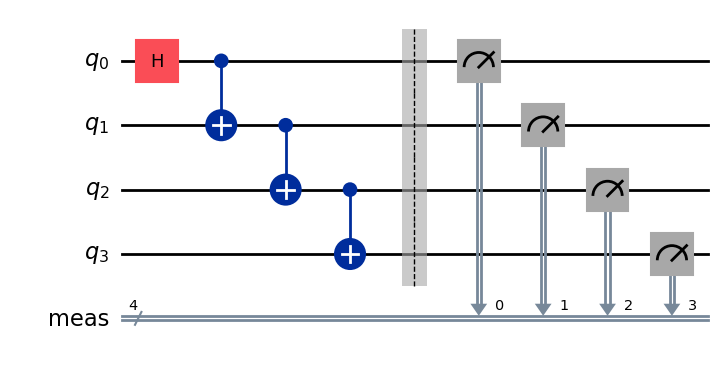

In [6]:
#  step 1: let's build a 4 qubit ghz state
n = 4
circuit = QuantumCircuit(n)
circuit.h(0)
for i in range(n - 1):
  circuit.cx(i, i+1)

circuit.measure_all()
# print(circuit.draw('mpl'))
circuit.draw('mpl')

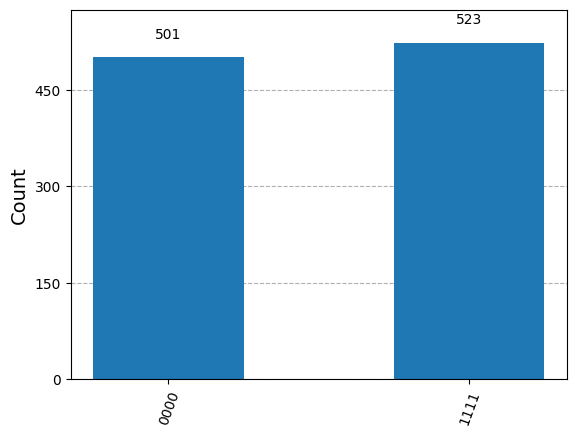

In [7]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circuit).result()
counts = result_ideal.get_counts(0)
plot_histogram(result_ideal.get_counts(0))

In [8]:
# create an empty NoiseModel
noise_model = NoiseModel()

# let's add depolarizing error to all single qubit gates

error = depolarizing_error(0.1, num_qubits=1)   # 10% noise

noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3", "h", "x", "y", "z", "s"])

print(noise_model)   #it will print noise model information


# p_error: 0.2 -> very noisy, 0.01 -> noise free system...

# let's add depolarizing error to specific single qubit gates
"""error = depolarizing_error(0.1, num_qubits=1)
noise_model.add_quantum_error(error, ["u1", "u2", "u3"], [0])
print(noise_model)"""

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 's', 'sx', 'u1', 'u2', 'u3', 'x', 'y', 'z']
  Instructions with noise: ['s', 'h', 'u3', 'u2', 'u1', 'z', 'y', 'x']
  All-qubits errors: ['u1', 'u2', 'u3', 'h', 'x', 'y', 'z', 's']


'error = depolarizing_error(0.1, num_qubits=1)\nnoise_model.add_quantum_error(error, ["u1", "u2", "u3"], [0])\nprint(noise_model)'

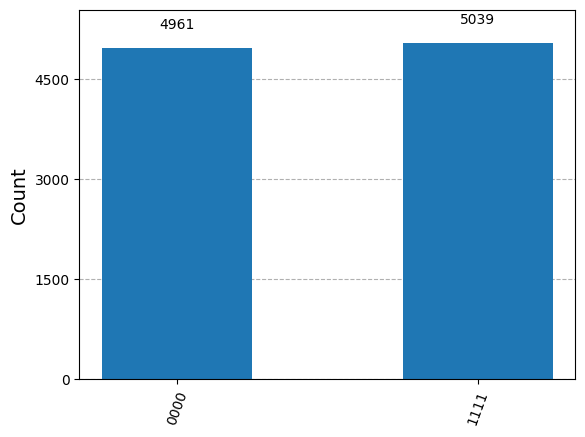

In [9]:
# noisy simulator and execution
from qiskit import transpile
sim_ideal = AerSimulator(noise_model=noise_model, method='statevector')  #create a noisy simulator backend
circuit = transpile(circuit, sim_ideal)
result_ideal = sim_ideal.run(circuit, shots=10000).result()
counts = result_ideal.get_counts(0)
plot_histogram(result_ideal.get_counts(0))

Figure(914.831x451.5)


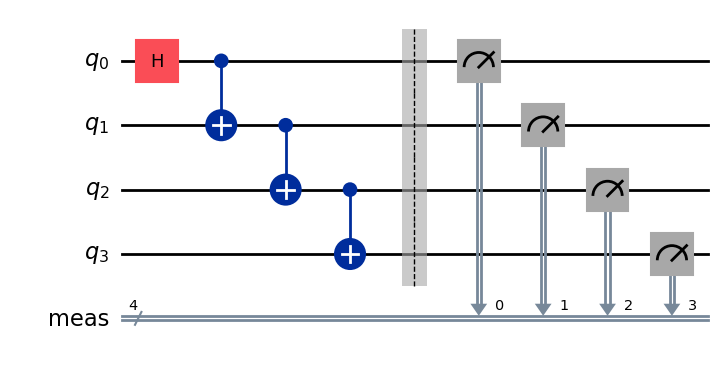

In [10]:
#  step 1: let's build a 4 qubit ghz state
n = 4
circ = QuantumCircuit(n)
circ.h(0)
for i in range(n - 1):
  circ.cx(i, i+1)

circ.measure_all()
print(circuit.draw('mpl'))
circ.draw('mpl')

In [11]:
"""from qiskit_aer.noise import NoiseModel, pauli_error

# Create a noise model with a bit-flip error on qubit 0
noisemodel_bitflip = NoiseModel()
bit_flip_error = pauli_error([("X", 0.1), ("I", 0.9)])  # 10% chance of bit flip
noisemodel_bitflip.add_all_qubit_quantum_error(bit_flip_error, ["id", "x", "h"])"""

'from qiskit_aer.noise import NoiseModel, pauli_error\n\n# Create a noise model with a bit-flip error on qubit 0\nnoisemodel_bitflip = NoiseModel()\nbit_flip_error = pauli_error([("X", 0.1), ("I", 0.9)])  # 10% chance of bit flip\nnoisemodel_bitflip.add_all_qubit_quantum_error(bit_flip_error, ["id", "x", "h"])'

In [13]:
#  bit flip noise model
# example error probabilities

p_gate1 = 0.05
p_meas = 0.2
p_reset = 0.05 #5% chance of a bit-flip error during the reset operation.

error_gate = pauli_error([('X', p_gate1), ('I', 1 - p_gate1)])  # with probability 1−p, there is no error and with probability p, there is a bit-flip error.
# error_meas = readout_error([('X', p_meas), ('I', 1 - p_meas)])
error_meas = ReadoutError([[1 - p_meas, p_meas], [p_meas, 1 - p_meas]])
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_gate2 = error_gate.tensor(error_gate) #both qubits will experiencthe same error probability modeling noise on 2 qubit gates

#  let's add the errors to the noise model

noisemodel_bitflip = NoiseModel()
noisemodel_bitflip.add_all_qubit_quantum_error(error_gate, ['u1', 'u2', 'u3'])
noisemodel_bitflip.add_all_qubit_quantum_error(error_reset, ['reset'])
noisemodel_bitflip.add_all_qubit_readout_error(error_meas)

print(noisemodel_bitflip)  #print the noise model



NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['reset', 'measure', 'u3', 'u2', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3', 'reset', 'measure']


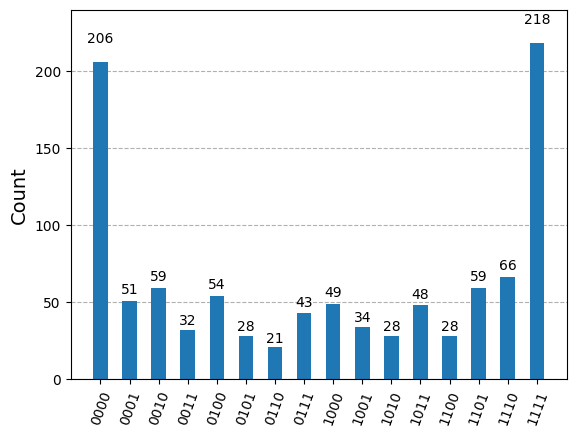

In [14]:
# simulate the noise model
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noisemodel_bitflip)

# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(
    optimization_level=3, backend=sim_noise
)
circ_tnoise = passmanager.run(circ)

# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)

# Plot noisy output
plot_histogram(counts_bit_flip)

In [15]:
# phase damping
from qiskit_aer.noise import phase_damping_error
n = 4
circ2 = QuantumCircuit(n)
circ2.h(0)
for i in range(n - 1):
  circ2.cx(i, i+1)

circ2.measure_all()
# print(circuit.draw('mpl'))
circ2.draw('mpl')

error = 0.5  #probability of phase damping
noisemodel_phasedamping = NoiseModel()

phasedamping_error = phase_damping_error(error, 1)
noisemodel_phasedamping.add_all_qubit_quantum_error(phasedamping_error, ["h"])
# noise_model.add_all_qubit_quantum_error(depolarizing_error(0.2, num_qubits=1), ["h", "cx"])

print(noisemodel_phasedamping)

NoiseModel:
  Basis gates: ['cx', 'h', 'id', 'rz', 'sx']
  Instructions with noise: ['h']
  All-qubits errors: ['h']


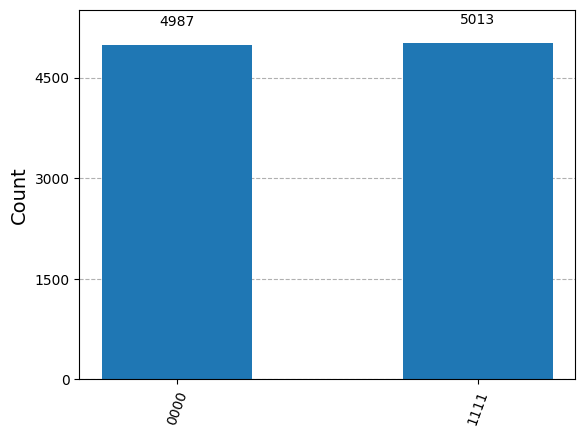

In [16]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noisemodel_phasedamping)

# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(
    optimization_level=3, backend=sim_noise
)
circ_tnoise = passmanager.run(circ2)

# Run and get counts
result_noise = sim_noise.run(circ_tnoise, shots=10000).result()
counts_noise = result_noise.get_counts()
plot_histogram(counts_noise)

In [ ]:
from qiskit_ibm_runtime import IBMQ
IBMQ.save_account('62c72edf4b8d2532ca8596d72102e90c72038ffa88fe2e5e6a556a70bfcaef41bde7f07cf4d0eca0fb8eddc2b3867e98eb295237ed20c87acea659173b386a89', overwrite=True)  # Run this only once
IBMQ.load_account()  # Load your IBMQ account


ImportError: cannot import name 'IBMQ' from 'qiskit_ibm_runtime' (/usr/local/lib/python3.10/dist-packages/qiskit_ibm_runtime/__init__.py)

In [18]:
# combining all the noise together
combined_noise_model = NoiseModel()
combined_noise_model.add_all_qubit_quantum_error(depolarizing_error(0.1, 1), ['h'])
combined_noise_model.add_all_qubit_quantum_error(phase_damping_error(0.2), ['h'])
combined_noise_model.add_all_qubit_quantum_error(pauli_error([("X", 0.1), ("I", 0.9)]), ['x'])

simulator = AerSimulator(noise_model=combined_noise_model)
compiled_circuit = transpile(circ2, simulator)
result = simulator.run(compiled_circuit).result()

print(result.get_counts())


{'1111': 500, '0000': 524}


In [19]:
# implementing shars code, which protects against bit and phase flip errors

def shor_code():
    qc = QuantumCircuit(9, 1)

    # Encoding
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)

    qc.cx(0, 3)
    qc.cx(1, 4)
    qc.cx(2, 5)

    qc.cx(3, 6)
    qc.cx(4, 7)
    qc.cx(5, 8)

    # Simulating a bit-flip error
    qc.x(4)  # Introduce an error

    # Decoding and error correction
    qc.cx(3, 0)
    qc.cx(4, 1)
    qc.cx(5, 2)

    qc.cx(6, 3)
    qc.cx(7, 4)
    qc.cx(8, 5)

    qc.ccx(3, 4, 0)
    qc.ccx(5, 6, 1)

    qc.measure(0, 0)

    return qc

shor_circuit = shor_code()
simulator = AerSimulator()
compiled_circuit = transpile(shor_circuit, simulator)
result = simulator.run(compiled_circuit).result()
print(result.get_counts())


{'0': 1024}


In [20]:
# more scalable error correction method SURFACE CODE

from qiskit import QuantumRegister, ClassicalRegister

def surface_code():
    qreg = QuantumRegister(5)
    creg = ClassicalRegister(1)
    qc = QuantumCircuit(qreg, creg)

    # Encoding
    qc.h(0)
    qc.cx(0, 1)
    qc.cx(0, 2)

    # Introduce an error
    qc.x(1)

    # Syndrome measurement
    qc.cx(1, 3)
    qc.cx(2, 3)
    qc.measure(3, 0)

    return qc

surface_circuit = surface_code()
simulator = AerSimulator()
compiled_circuit = transpile(surface_circuit, simulator)
result = simulator.run(compiled_circuit).result()
print(result.get_counts())


{'1': 1024}


In [ ]:
#  let's apply shor's code to the noisy circuit

shor_circuit = shor_code()
noisy_simulator = AerSimulator(noise_model=combined_noise_model)

compiled_circuit = transpile(shor_circuit, noisy_simulator)
result = noisy_simulator.run(compiled_circuit).result()

print(result.get_counts())


{'1': 128, '0': 896}


In [21]:
# let's compare results with and without error correction

# Without error correction
qc = QuantumCircuit(1, 1)
qc.h(0)
qc.x(0)  # Introduce bit-flip
qc.measure(0, 0)

noisy_simulator = AerSimulator(noise_model=combined_noise_model)
compiled_circuit = transpile(qc, noisy_simulator)
result = noisy_simulator.run(compiled_circuit).result()

print("Without error correction:", result.get_counts())

# With error correction (Shor code)
shor_circuit = shor_code()
compiled_circuit = transpile(shor_circuit, noisy_simulator)
result = noisy_simulator.run(compiled_circuit).result()

print("With error correction:", result.get_counts())


Without error correction: {'0': 528, '1': 496}
With error correction: {'1': 147, '0': 877}


In [22]:
# noise simulation with corrected errors using shor's algorithm
def simulate(qc, noise_model=None):
    simulator = AerSimulator(noise_model=noise_model) if noise_model else AerSimulator()
    compiled_circuit = transpile(qc, simulator)
    result = simulator.run(compiled_circuit).result()
    return result.get_counts()

qc = QuantumCircuit(1, 1)
qc.h(0)
qc.measure(0, 0)

print("Noisy Simulation:", simulate(qc, combined_noise_model))
print("With Error Correction:", simulate(shor_code(), combined_noise_model))


Noisy Simulation: {'0': 518, '1': 506}
With Error Correction: {'1': 135, '0': 889}


Grover's Algorithm

In [26]:
# Built-in modules
import math

# Imports from Qiskit
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution

# Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [ ]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
# service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
# backend.name

In [27]:
def grover_oracle(marked_states):
    """Build a Grover oracle for multiple marked states

    Here we assume all input marked states have the same number of bits

    Parameters:
        marked_states (str or list): Marked states of oracle

    Returns:
        QuantumCircuit: Quantum circuit representing Grover oracle
    """
    if not isinstance(marked_states, list):
        marked_states = [marked_states]
    # Compute the number of qubits in circuit
    num_qubits = len(marked_states[0])

    qc = QuantumCircuit(num_qubits)
    # Mark each target state in the input list
    for target in marked_states:
        # Flip target bit-string to match Qiskit bit-ordering
        rev_target = target[::-1]
        # Find the indices of all the '0' elements in bit-string
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        # Add a multi-controlled Z-gate with pre- and post-applied X-gates (open-controls)
        # where the target bit-string has a '0' entry
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    return qc

<ipython-input-27-6de8e9ca2dbc>:27: DeprecationWarning: The class ``qiskit.circuit.library.generalized_gates.mcmt.MCMT`` is deprecated as of qiskit 1.4. It will be removed no earlier than 3 months after the release date. Use MCMTGate instead.
  qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)


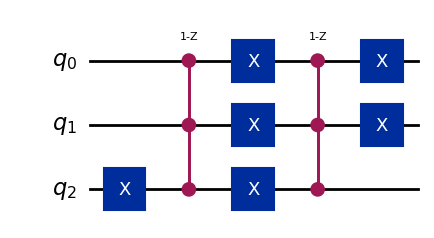

In [29]:
marked_states = ["011", "100"]

oracle = grover_oracle(marked_states)
oracle.draw(output="mpl", style="iqp")

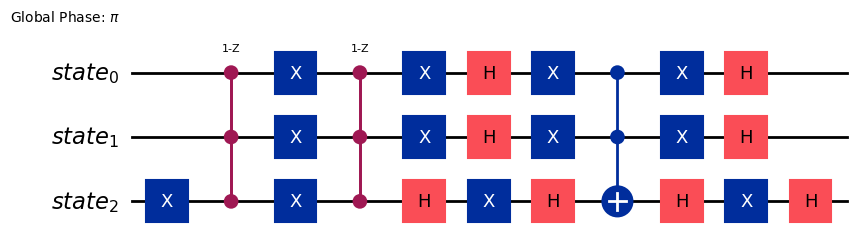

In [30]:
grover_op = GroverOperator(oracle)
grover_op.decompose().draw(output="mpl", style="iqp")

In [31]:
optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(len(marked_states) / 2**grover_op.num_qubits)))
)

Full grover circuit

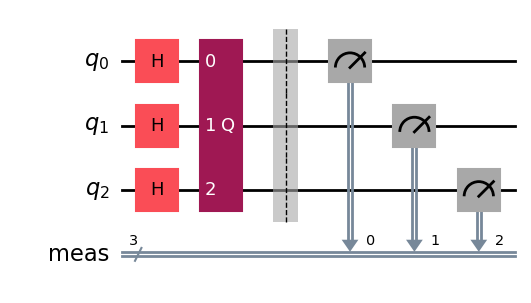

In [32]:
qc = QuantumCircuit(grover_op.num_qubits)
# Create even superposition of all basis states
qc.h(range(grover_op.num_qubits))
# Apply Grover operator the optimal number of times
qc.compose(grover_op.power(optimal_num_iterations), inplace=True)
# Measure all qubits
qc.measure_all()
qc.draw(output="mpl", style="iqp")

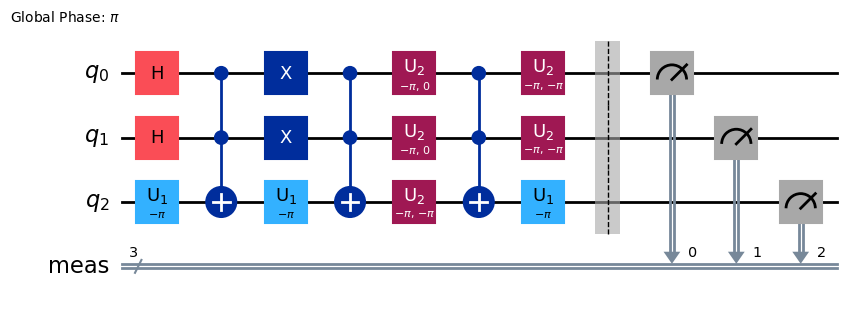

In [33]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend = AerSimulator()
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

circuit_isa = pm.run(qc)
circuit_isa.draw(output="mpl", idle_wires=False, style="iqp")

In [34]:
# To run on local simulator:
#   1. Use the SatetvectorSampler from qiskit.primitives instead
sampler = Sampler(mode=backend)
sampler.options.default_shots = 10_000
result = sampler.run([circuit_isa]).result()
dist = result[0].data.meas.get_counts()

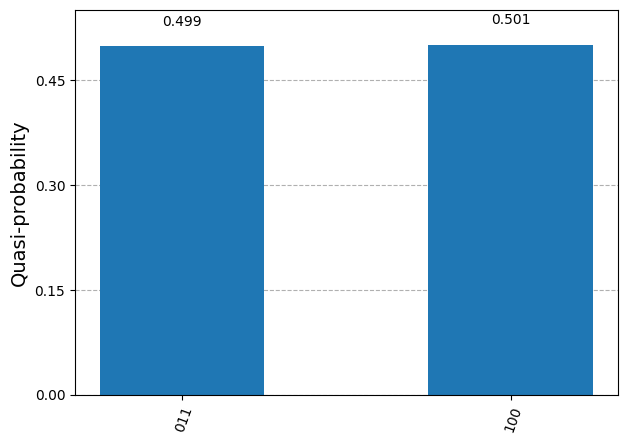

In [35]:
plot_distribution(dist)

In [ ]:
import qiskit_ibm_runtime

qiskit_ibm_runtime.version.get_version_info()

'0.36.1'

In [ ]:
import qiskit

qiskit.version.get_version_info()

'1.3.2'

In [36]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# Create Quantum and Classical Registers
qr = QuantumRegister(2, name='q')
cr = ClassicalRegister(2, name='c')
grover = QuantumCircuit(qr, cr)

# Apply Hadamard gates
grover.h(qr)

# Oracle for state |11>
grover.cz(qr[0], qr[1])

# Diffuser
grover.h(qr)
grover.x(qr)
grover.h(qr[1])
grover.cx(qr[0], qr[1])
grover.h(qr[1])
grover.x(qr)
grover.h(qr)

# Measurement
grover.measure(qr, cr)

# Draw the circuit
print(grover)



     ┌───┐   ┌───┐┌───┐          ┌───┐┌───┐     ┌─┐   
q_0: ┤ H ├─■─┤ H ├┤ X ├───────■──┤ X ├┤ H ├─────┤M├───
     ├───┤ │ ├───┤├───┤┌───┐┌─┴─┐├───┤├───┤┌───┐└╥┘┌─┐
q_1: ┤ H ├─■─┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├┤ X ├┤ H ├─╫─┤M├
     └───┘   └───┘└───┘└───┘└───┘└───┘└───┘└───┘ ║ └╥┘
c: 2/════════════════════════════════════════════╩══╩═
                                                 0  1 


In [37]:
# from qiskit.providers.aer import AerSimulator
# from qiskit.providers.aer.noise import NoiseModel, depolarizing_error

# Create a noise model
noise_model = NoiseModel()

# Depolarizing error probabilities
p1 = 0.01  # Single-qubit gate error probability
p2 = 0.02  # Two-qubit gate error probability

# Add errors to the noise model
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])

# Simulate the circuit with noise
simulator = AerSimulator(noise_model=noise_model)
job = simulator.run(grover, shots=1000)
result = job.result()
counts = result.get_counts(grover)
print(counts)


{'01': 4, '00': 3, '10': 5, '11': 988}


In [38]:
# from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit_experiments.library import StateTomography   # changed the import to qiskit_experiments

# Generate measurement calibration circuits
# meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='measerrormit')
# changed to use the StateTomography class
# which is the new way of setting up tomography experiments in Qiskit Experiments.

# Prepare the tomography experiment
# The StateTomography class allows you to specify the circuits needed for tomography
# and provides tools for analyzing the results
tomo_exp = StateTomography(grover) # grover contains circuit

# Generate the tomography circuits
tomo_circuits = tomo_exp.circuits()

# Execute the tomography circuits
# Note that in your original code, you were running the calibration circuits on a simulator
# We can update that to use the Aer simulator as an example here

backend = AerSimulator()
job = backend.run(tomo_circuits)
# compiled_circuit = transpile(shor_circuit, simulator)
# result = simulator.run(compiled_circuit).result()
# Get the results
# result = backend.run(tomo_circuits).result()
# Process the results to reconstruct the density matrix
#tomo_results = tomo_exp.analysis.run(result)  # or result to directly analyze the results
# Get the counts
counts = result.get_counts()


# Apply measurement error mitigation if desired
# (There is an option to apply error mitigation to the resulting state of state tomography)

#from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit_experiments.library import StateTomography   # changed the import to qiskit_experiments
from qiskit import transpile

# ... (rest of your code) ...

backend = AerSimulator()

# Transpile the tomography circuits to the basis gates supported by the backend
# This will replace PauliMeasZ with supported gates like measure and z gates.
transpiled_tomo_circuits = [transpile(circ, backend) for circ in tomo_circuits]

job = backend.run(transpiled_tomo_circuits)

# ... (rest of your code) ...
print("Mitigated counts:", counts)  # changed mitigated_counts to counts

Mitigated counts: {'01': 4, '00': 3, '10': 5, '11': 988}


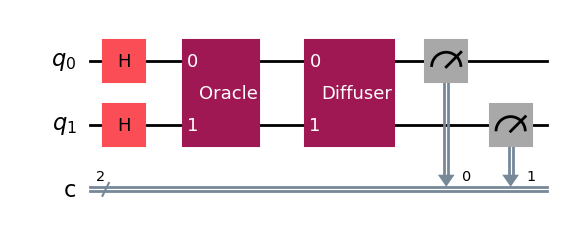

In [39]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
import numpy as np

# Define the oracle for |11> as the marked state
oracle = QuantumCircuit(2)
oracle.cz(0, 1)  # Apply controlled-Z gate
oracle.to_gate()
oracle.name = "Oracle"

# Define the diffusion operator
diffuser = QuantumCircuit(2)
diffuser.h([0, 1])
diffuser.x([0, 1])
diffuser.h(1)
diffuser.cx(0, 1)
diffuser.h(1)
diffuser.x([0, 1])
diffuser.h([0, 1])
diffuser.to_gate()
diffuser.name = "Diffuser"

# Grover's Algorithm Circuit
grover = QuantumCircuit(2, 2)
grover.h([0, 1])  # Apply Hadamard gates
grover.append(oracle, [0, 1])
grover.append(diffuser, [0, 1])
grover.measure([0, 1], [0, 1])

grover.draw('mpl')


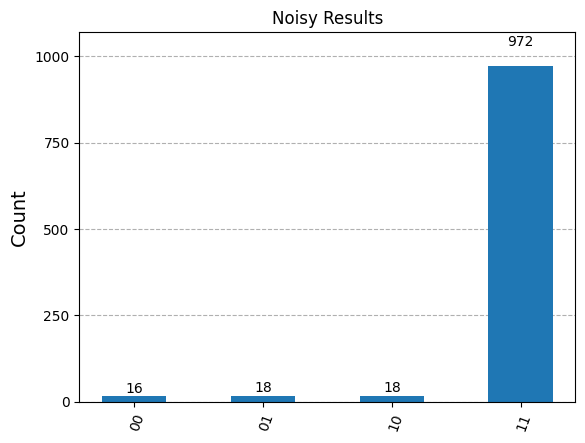

In [40]:
# from qiskit.providers.aer import AerSimulator
# from qiskit.providers.aer.noise import NoiseModel, depolarizing_error

# Create a noise model
noise_model = NoiseModel()

# Add depolarizing error for single-qubit gates
p1 = 0.01  # Probability of depolarizing error
p2 = 0.02  # Probability of depolarizing error for 2-qubit gates
noise_model.add_all_qubit_quantum_error(depolarizing_error(p1, 1), ['h', 'x'])
noise_model.add_all_qubit_quantum_error(depolarizing_error(p2, 2), ['cx'])

# Simulate with noise
simulator = AerSimulator(noise_model=noise_model)
tqc = transpile(grover, simulator)
job = simulator.run(tqc)
result = job.result()
counts_noisy = result.get_counts()

plot_histogram(counts_noisy, title="Noisy Results")


In [41]:
#  from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter
from qiskit_experiments.library import StateTomography   # changed the import to qiskit_experiments

# Generate measurement calibration circuits
# meas_calibs, state_labels = complete_meas_cal(qr=qr, circlabel='measerrormit')
# changed to use the StateTomography class
# which is the new way of setting up tomography experiments in Qiskit Experiments.

# Prepare the tomography experiment
# The StateTomography class allows you to specify the circuits needed for tomography
# and provides tools for analyzing the results
tomo_exp = StateTomography(grover) # grover contains circuit

# Generate the tomography circuits
tomo_circuits = tomo_exp.circuits()

# Execute the tomography circuits
# Note that in your original code, you were running the calibration circuits on a simulator
# We can update that to use the Aer simulator as an example here

backend = AerSimulator()
job = backend.run(tomo_circuits)
# compiled_circuit = transpile(shor_circuit, simulator)
# result = simulator.run(compiled_circuit).result()
# Get the results
# result = backend.run(tomo_circuits).result()
# Process the results to reconstruct the density matrix
#tomo_results = tomo_exp.analysis.run(result)  # or result to directly analyze the results
# Get the counts
counts = result.get_counts()


In [52]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter

# Define parameters for variational Grover
theta = Parameter('θ')

# Variational Grover circuit
n = 3  # Number of qubits
qc = QuantumCircuit(n)

# Initial state
qc.h(range(n))

# Parameterized Oracle (Noise-Adaptive)
qc.cz(0, 1)
qc.rz(theta, 1)
qc.cz(1, 2)

# Diffusion Operator
qc.h(range(n))
qc.x(range(n))
qc.h(n-1)
qc.mcx(list(range(n-1)), n-1)
qc.h(n-1)
qc.x(range(n))
qc.h(range(n))

# Measurement
qc.measure_all()

# Simulate
backend = AerSimulator()
job = backend.run(qc)
# result = job.result()
counts = result.get_counts()

# Execute
job = backend.run(qc)
# result = job.result()
counts = result.get_counts()


In [55]:
counts = result.get_counts()
print("counts:", counts)

counts: {'00': 16, '10': 18, '01': 18, '11': 972}


In [58]:
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram

# Define the number of qubits
n = 4
qc = QuantumCircuit(n)

# Step 1: Apply Hadamard to create a superposition
qc.h(range(n))

# Step 2: Define Oracle for |1010⟩ (decimal 10)
oracle = QuantumCircuit(n)
oracle.cz(1, 3)  # Controlled Z on qubits 1 and 3 (corresponding to 1010)
qc.append(oracle.to_gate(label="Oracle"), range(n))

# Step 3: Grover Diffusion Operator
qc.h(range(n))
qc.x(range(n))
qc.h(n-1)
qc.mcx(list(range(n-1)), n-1)
qc.h(n-1)
qc.x(range(n))
qc.h(range(n))

# Step 4: Measure the qubits
qc.measure_all()

# Simulate
backend = AerSimulator()
job = backend.run(qc)
# result = job.result.get_counts()
counts = result.get_counts()

# Output results
plot_histogram(counts)
print(counts)


{'00': 16, '10': 18, '01': 18, '11': 972}


**Fidelity is a measure of how similar two quantum states are. It ranges from 0 to 1, where:**

Fidelity = 1 → The two states are identical (perfect match).


0 < Fidelity < 1 → The two states are partially similar, with higher values meaning more similarity.


Fidelity = 0 → The two states are completely different (orthogonal states).

In [ ]:
# fidelity to check whether the two states are

QEC

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.8/753.8 kB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 49.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.8/340.8 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 434.9/434.9 kB 31.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 69.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 kB 10.5 MB/s eta 0:00:00
  Attempting uninstall: pydantic-core
    Found existing installation: pydantic_core 2.27.2
    Uninstalling pydantic_core-2.27

In [ ]:
import qiskit
print(qiskit.__version__)


1.3.2


In [ ]:
!pip install qiskit --upgrade
